# Final assignment
Hannah Weiser \
Heidelberg University \
Institute of Geography \
Advanced Geoscripting \
Summer term 2020

The goal of the project is to perform an explorative data analysis on specific species of digger wasps and their prey. We are using the GBIF (Global Biodiversity Information Facility) API. GBIF provides free and open access to biodiversity data (https://www.gbif.org/).

First, we import the packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygbif import occurrences as occ  # python client for the GBIF API 
from pygbif import maps
import mplleaflet
import geopandas as gpd
%matplotlib inline

In [2]:
isodontia_dict = occ.search(scientificName = 'Isodontia mexicana')
isodontia_occs = isodontia_dict['results']

Let's display all keys in the first occurece.

In [3]:
display(isodontia_occs[0].keys())

dict_keys(['key', 'datasetKey', 'publishingOrgKey', 'installationKey', 'publishingCountry', 'protocol', 'lastCrawled', 'lastParsed', 'crawlId', 'extensions', 'basisOfRecord', 'occurrenceStatus', 'taxonKey', 'kingdomKey', 'phylumKey', 'classKey', 'orderKey', 'familyKey', 'genusKey', 'speciesKey', 'acceptedTaxonKey', 'scientificName', 'acceptedScientificName', 'kingdom', 'phylum', 'order', 'family', 'genus', 'species', 'genericName', 'specificEpithet', 'taxonRank', 'taxonomicStatus', 'dateIdentified', 'decimalLongitude', 'decimalLatitude', 'coordinateUncertaintyInMeters', 'stateProvince', 'year', 'month', 'day', 'eventDate', 'issues', 'modified', 'lastInterpreted', 'references', 'license', 'identifiers', 'media', 'facts', 'relations', 'gadm', 'geodeticDatum', 'class', 'countryCode', 'recordedByIDs', 'identifiedByIDs', 'country', 'rightsHolder', 'identifier', 'http://unknown.org/nick', 'verbatimEventDate', 'datasetName', 'gbifID', 'collectionCode', 'verbatimLocality', 'occurrenceID', 'tax

What's the coordinate system of the first occurence?

In [4]:
print(isodontia_occs[0]['geodeticDatum'])

WGS84


For further analyses, we want to work with a dataframe instead of a dictionary.

In [5]:
df_isodontia = pd.DataFrame.from_dict(isodontia_occs)
display(df_isodontia.head())
df_isodontia = df_isodontia.astype({'eventDate':'datetime64', 'dateIdentified':'datetime64'})

,key,datasetKey,publishingOrgKey,installationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,extensions,...,sex,lifeStage,eventRemarks,taxonRemarks,organismRemarks,collectionID,individualCount,continent,dataGeneralizations,higherClassification
0,2597845815,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T15:56:23.096+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2603300247,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T16:12:28.193+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2626578683,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T16:13:51.389+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2634131701,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T15:57:04.229+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2634531585,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T16:13:38.922+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's also save this immediately, so our workflow will be really reproducible.

In [6]:
df_isodontia.to_csv("gbif_occ_isodontia_mexicana.csv")

For now, we are only interested in the locations and the event date and only want occurences within europe. We should convert our dataframe to a geodataframe.

For plotting later, we have to make sure our Lat and Long columns do not contain NaN values, otherwise we will not get a plot with mplleaflet basemap.
Let's check if there are NaNs.

In [7]:
print(df_isodontia[['decimalLatitude', 'decimalLongitude']].isnull().sum().sum())

2


Looks like we have an entry with NaN values. We remove it with the `pd.dropna()` method.

In [8]:
df_isodontia = df_isodontia.dropna(subset=['decimalLatitude', 'decimalLongitude'])
gdf_isodontia = gpd.GeoDataFrame(df_isodontia, geometry=gpd.points_from_xy(df_isodontia.decimalLongitude, df_isodontia.decimalLatitude))
display(gdf_isodontia.head())

,key,datasetKey,publishingOrgKey,installationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,extensions,...,lifeStage,eventRemarks,taxonRemarks,organismRemarks,collectionID,individualCount,continent,dataGeneralizations,higherClassification,geometry
0,2597845815,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T15:56:23.096+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-100.38803 20.52219)
1,2603300247,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T16:12:28.193+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-97.88640 30.20881)
2,2626578683,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T16:13:51.389+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-92.92551 45.00075)
3,2634131701,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T15:57:04.229+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (7.83430 48.01588)
4,2634531585,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T16:13:38.922+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (8.68147 49.39040)


In [9]:
print(gdf_isodontia[['decimalLatitude', 'decimalLongitude']].isnull().sum().sum())

0


Let's see if we can plot it now. We will colour the points of occurences by the eventDate to see if we can get an idea how the species was spreading. 

In [10]:
fig, ax = plt.subplots()
gdf_isodontia.plot(ax=ax, c=gdf_isodontia['eventDate'], cmap='Blues')
#plt.colorbar()
mplleaflet.display(fig=fig)

c:\users\hannah\anaconda3\envs\gbif\lib\site-packages\mplleaflet\mplexporter\exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]
c:\users\hannah\anaconda3\envs\gbif\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


We now want to look at one of the preys of this species and its distribution. Let's get the data. We will write a function, so we can easily retrieve the data for many species.

In [11]:
def species_occurences_to_gdf(species_name):
    occ_dict = occ.search(scientificName=species_name)
    occ_df = pd.DataFrame.from_dict(occ_dict['results'])
    occ_df = occ_df.astype({'dateIdentified':'datetime64'})
    occ_df = occ_df.dropna(subset=['decimalLatitude', 'decimalLongitude'])
    occ_df.to_csv("gbif_occ_" + species_name.replace(" ","_") + ".csv")
    occ_gdf = gpd.GeoDataFrame(occ_df, geometry=gpd.points_from_xy(occ_df.decimalLongitude, occ_df.decimalLatitude))
    return occ_gdf

In [12]:
colors=["blue", "orange", "red"]
plots = []
fig, ax = plt.subplots()
species_list = ['Isodontia mexicana', 'Meconema meridionale', 'Meconema thalassinum']
for i, species in enumerate(species_list): 
    df = species_occurences_to_gdf(species)
    plots.append(df.plot(ax=ax, c=colors[i]))

#plt.legend(handles=plots, labels=species)
#plt.show()
mplleaflet.display(fig=fig)

c:\users\hannah\anaconda3\envs\gbif\lib\site-packages\mplleaflet\mplexporter\exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]
c:\users\hannah\anaconda3\envs\gbif\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


(Unfortunately, mplleaflet does not let us plot legends.)

Interesting. We want to limit our further analysis to Europe. There is a continent tag in gbif, but it is not used in our dataset. We could furthermore filter by countries but then we would have to list them all. So let's just get another geometry of the entire Europe and use the `GeoSeries.within()` method.

The administrative data (`NUTS_BN_60M_2021_3857_LEVL_0.shp`) is downloaded from here: https://ec.europa.eu/eurostat/de/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts#nuts21


In [13]:
fp = "./NUTS_RG_60M_2021_4326_LEVL_0.shp/NUTS_RG_60M_2021_4326_LEVL_0.shp"
gdf_european_countries = gpd.read_file(fp)

Let's check the GeoDataFrame to see if the download worked.

In [14]:
gdf_european_countries.head()

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,DK,0,DK,Danmark,Danmark,0,None,None,DK,"MULTIPOLYGON (((10.19900 56.68400, 10.81800 56..."
1,RS,0,RS,Serbia,Srbija/Сpбија,0,None,None,RS,"POLYGON ((21.47900 45.19300, 21.35800 44.82200..."
2,EE,0,EE,Eesti,Eesti,0,None,None,EE,"MULTIPOLYGON (((27.35700 58.78700, 27.64500 57..."
3,EL,0,EL,Elláda,Ελλάδα,0,None,None,EL,"MULTIPOLYGON (((26.03300 40.73000, 25.63200 40..."
4,ES,0,ES,España,España,0,None,None,ES,"MULTIPOLYGON (((-7.03200 43.54400, -5.85400 43..."


Let's unify them to get one geometry with the entire europe.

In [15]:
gdf_europe = gdf_european_countries.dissolve(by="LEVL_CODE")[['geometry']]
display(gdf_europe)

,geometry
LEVL_CODE,
0,"MULTIPOLYGON (((55.85000 -21.18600, 55.78600 -..."


Looks good. We now use the `GeoSeries.within()` method to only get observations within europe. We'll get a CRS misatch warning because we did not set the CRS for the `gdf_isodontia` dataframe yet. So that will be the first step.

<AxesSubplot:>

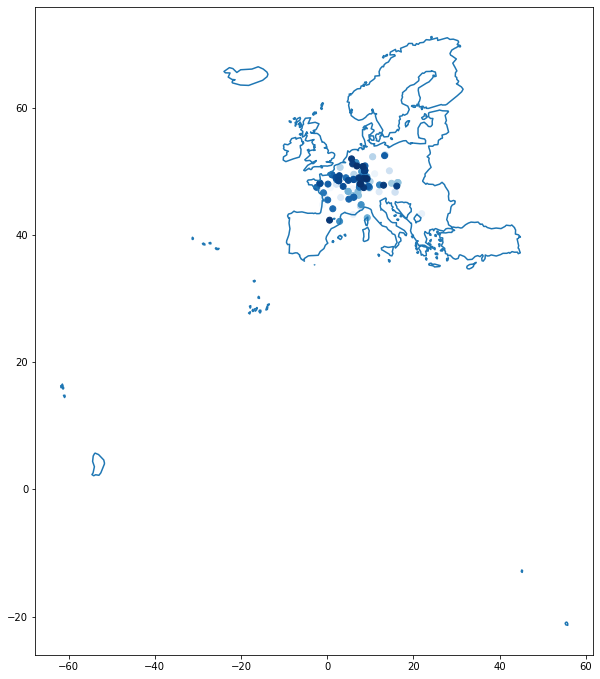

In [24]:
gdf_isodontia.set_crs(epsg=4326, inplace=True)
gdf_isodontia_europe = gpd.clip(gdf_isodontia, gdf_europe)
#gdf_isodontia.loc[gdf_isodontia['geometry'].within(gdf_europe['geometry'])]
#display(gdf_isodontia_europe)
fig, ax = plt.subplots(figsize=(10,30))
gdf_europe.geometry.boundary.plot(ax=ax)
gdf_isodontia_europe.plot(ax=ax, c=gdf_isodontia['eventDate'], cmap='Blues')

Let's adapt our previous function to clip any extracted species to the extent given by another gdf. 

In [25]:
def species_occs_europe_to_gdf(species_name, clip_gdf):
    occ_dict = occ.search(scientificName=species_name)
    occ_df = pd.DataFrame.from_dict(occ_dict['results'])
    occ_df = occ_df.astype({'dateIdentified':'datetime64'})
    occ_df = occ_df.dropna(subset=['decimalLatitude', 'decimalLongitude'])
    occ_df.to_csv("gbif_occ_" + species_name.replace(" ","_") + ".csv")
    occ_gdf = gpd.GeoDataFrame(occ_df, geometry=gpd.points_from_xy(occ_df.decimalLongitude, occ_df.decimalLatitude))
    crs = clip_gdf.crs
    print(crs)
    occ_gdf.set_crs(epsg=4326, inplace=True)
    occ_gdf_clipped = gpd.clip(occ_gdf, clip_gdf)

    return occ_gdf_clipped